# MODIS Cloud Top Pressure Retrieval

This notebook demsontrates the application of QRNNs to retrieve cloud-top pressure (CTP) from MODIS infrared observations. A similar retrieval will be used in the next version of the EUMETSAT PPS package, for the production
of near-real time (NRT) Meteorological data to support Nowcasting activities.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Downloading the data

In [3]:
from quantnn.examples.modis_ctp import download_data
download_data()

## Loading and preparing the training data

In [4]:
import pathlib
from quantnn.normalizer import Normalizer
training_data = np.load("data/ctp_training_data.npz")
x_train, y_train = training_data["x"], training_data["y"]

In [5]:
from quantnn.normalizer import Normalizer
normalizer = Normalizer(x_train)
x_train = normalizer(x_train)

## Defining a neural network model

In [6]:
quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]

In [7]:
import torch
import torch.nn as nn

n_layers = 4
n_neurons = 256

# First block
layers = [nn.Linear(16, n_neurons), nn.BatchNorm1d(n_neurons), nn.ReLU(), ]
# Center blocks
for _ in range(n_layers):
    layers.extend([nn.Linear(n_neurons, n_neurons), nn.BatchNorm1d(n_neurons), nn.ReLU()])
# Final block
layers.append(nn.Linear(n_neurons, len(quantiles)))

model = nn.Sequential(*layers)

## Training the neural network

In [8]:
from quantnn import QRNN

qrnn = QRNN(16,
            quantiles=quantiles,
            model=model)

In [9]:
from torch.utils.data import TensorDataset, DataLoader
x_tensor = torch.tensor(x_train).float()
y_tensor = torch.tensor(y_train).float()
training_data = TensorDataset(x_tensor, y_tensor)
training_loader = DataLoader(training_data,
                             batch_size=256,
                             shuffle=True,
                             num_workers=4)

In [10]:
n_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
qrnn.train(training_loader,
           optimizer=optimizer,
           learning_rate_scheduler=scheduler,
           maximum_epochs=n_epochs,
           gpu=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
qrnn.train(training_loader,
           optimizer=optimizer,
           learning_rate_scheduler=scheduler,
           maximum_epochs=n_epochs,
           gpu=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
qrnn.train(training_loader,
           optimizer=optimizer,
           learning_rate_scheduler=scheduler,
           maximum_epochs=n_epochs,
           gpu=True)

Epoch 0 / 10: Training error: 34.963, Learning rate: 0.10000
Epoch 1 / 10: Training error: 32.653, Learning rate: 0.09755
Epoch 2 / 10: Training error: 32.133, Learning rate: 0.09045
Epoch 3 / 10: Training error: 31.742, Learning rate: 0.07939
Epoch 4 / 10: Training error: 31.396, Learning rate: 0.06545
Epoch 5 / 10: Training error: 31.066, Learning rate: 0.05000
Epoch 6 / 10: Training error: 30.753, Learning rate: 0.03455
Epoch 7 / 10: Training error: 30.432, Learning rate: 0.02061
Epoch 8 / 10: Training error: 30.140, Learning rate: 0.00955
Epoch 9 / 10: Training error: 29.929, Learning rate: 0.00245
Epoch 0 / 10: Training error: 30.030, Learning rate: 0.01000
Epoch 1 / 10: Training error: 29.976, Learning rate: 0.00976
Epoch 2 / 10: Training error: 29.886, Learning rate: 0.00905
Epoch 3 / 10: Training error: 29.790, Learning rate: 0.00794
Epoch 4 / 10: Training error: 29.686, Learning rate: 0.00655
Epoch 5 / 10: Training error: 29.582, Learning rate: 0.00500
Epoch 6 / 10: Training e

{'training_errors': [34.96302134951428,
  32.652711455019244,
  32.133143600556885,
  31.741617386200275,
  31.39597972715501,
  31.065947406485233,
  30.752566152717197,
  30.43191773497891,
  30.14025138122212,
  29.928854503228404,
  30.030475628748455,
  29.975567009142665,
  29.885609233672103,
  29.789648770574427,
  29.685931983847546,
  29.582355891856338,
  29.480416159888666,
  29.377144367384723,
  29.306708896197883,
  29.253592518632555,
  29.235591099567,
  29.23368072010677,
  29.23438227591118,
  29.222036206914485,
  29.232455404505075,
  29.22961513030337,
  29.217933126428917,
  29.226466187209258,
  29.21943082458895,
  29.211985570224353],
 'validation_errors': []}

## Applying the CTP retrieval

To validate the CTP retrieval, we will apply the retrieval to observations of Hurricane Nicole of the 2016 Hurricane season and compare the results to the cloud-top pressure determined by the CALIOP lidar on the CALIPSO satellite, which is also used as reference to generate the training data.


In [19]:
validation_data = np.load("data/ctp_validation_data.npz")

# Overview over full MODIS observations.
lons_rgb = validation_data["longitude_rgb"]
lats_rgb = validation_data["latitude_rgb"]
modis_rgb = validation_data["modis_rgb"]
modis_bt_11 = validation_data["bt_11_rgb"]
modis_bt_12 = validation_data["bt_12_rgb"]

# Caliop obervations used as reference
lons_c = validation_data["longitude"]
lats_c = validation_data["latitude"]
ctp_c = validation_data["ctp"]
input_data = validation_data["input_data"]

### Hurricane Nicole

The plot below shows an overview of the scene the we will be using to validate the retrieval. The scene depicts an overpass of the CALIOP lidar over Hurricane Nicole from the 2016 Hurrican season. The line plotted ontop of the true-color image in panel (a) displays the swath of the CALIOP lidar. As you can see, it passed directly through the eye of the Hurricane.

Panel (b) and (c) show the MODIS observations that are used as input for the retrieval. The two channels are located in the far infrared region and thus measure thermal emission from the atmosphere. Nicole's high clouds are visible as cold regions in the image since the radiation is emitted higher up in the atmosphere, where it is colder.`

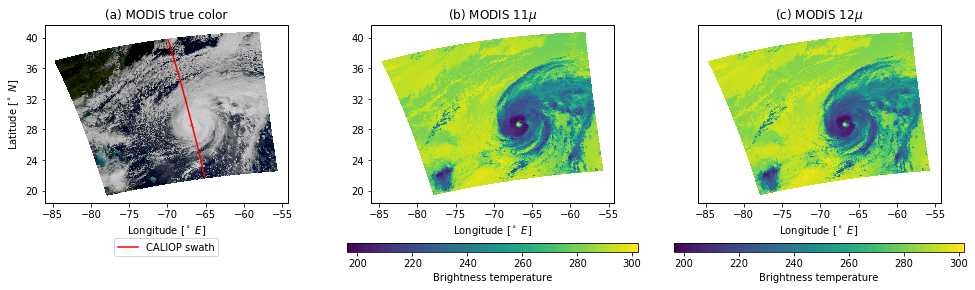

In [20]:
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

f = plt.figure(figsize=(14, 4))
gs = GridSpec(2, 3, height_ratios=[1.0, 0.05])

ax = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
colors = modis_rgb[:-1, :-1].reshape(-1, 4) / 256.0
l = plt.plot(lons_c, lats_c, c="r")
ax.pcolormesh(lons_rgb, lats_rgb, lons_rgb, color=colors)
ax.set_xticks(np.linspace(-85, -55, 7))
ax.set_xlabel("Longitude [$^\circ\ E$]")
ax.set_yticks(np.linspace(20, 40, 6))
ax.set_ylabel("Latitude [$^\circ\ N$]")
ax.set_title("(a) MODIS true color")
ax = plt.subplot(gs[1, 0])
ax.set_axis_off()
ax.legend(handles=l, labels=["CALIOP swath"], loc="center")

ax = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
m = ax.pcolormesh(lons_rgb, lats_rgb, modis_bt_11)
ax.set_xticks(np.linspace(-85, -55, 7))
ax.set_xlabel("Longitude [$^\circ\ E$]")
ax.set_yticks(np.linspace(20, 40, 6))
ax.set_title("(b) MODIS $11\mu$")
ax = plt.subplot(gs[1, 1])
plt.colorbar(m, cax=ax, orientation="horizontal", label="Brightness temperature")

ax = plt.subplot(gs[0, 2], projection=ccrs.PlateCarree())
img = ax.pcolormesh(lons_rgb, lats_rgb, modis_bt_12)
ax.set_xticks(np.linspace(-85, -55, 7))
ax.set_xlabel("Longitude [$^\circ\ E$]")
ax.set_title("(c) MODIS $12\mu$")
ax = plt.subplot(gs[1, 2])
plt.colorbar(m, cax=ax, orientation="horizontal", label="Brightness temperature")

f.canvas.draw()
plt.tight_layout()

### Running the retrieval

The validation data comes with pre-processed observation along the CALOP swath. Evaluating the retrieval therfore only requires normalizing the data (using the same normalizer that was used during training) and evaluating the network prediction.

In [575]:
y_pred = qrnn.predict(normalizer(input_data))

# CALIOP reference data
y_ref = ctp_c[:, 0]
y_ref[y_ref < 0.0] = np.nan

The plot below shows the QRNN-predicted cloud-top pressure as confidence intervals together with the reference data from the CALIOP LIDAR (black markers). Although there is considerable uncertainty in the retrieval, all reference values lie withing the predicted intervals.

However, the cloud-top pressure of the hurricane seems to be rather consistently underestimating the reference pressure, which indicates that the the uncertainty estimates are not very well calibrated in this region. This is expected, to some extent, because the QRNN learned to predicted uncertainty based on the a-priori distribution of cloud-top pressures in the training data, which is quite different from those of the Hurricane.

Text(0.5, 0, 'Latitude [$^\\circ\\ N$]')

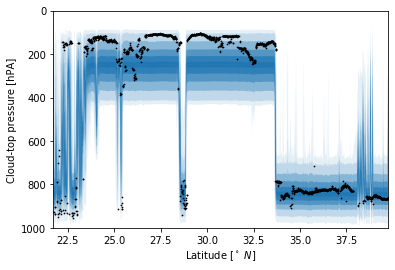

In [576]:
from quantnn.plotting import plot_confidence_intervals

f, ax = plt.subplots(1, 1)
plot_confidence_intervals(ax, lats_c, y_pred, qrnn.quantiles)
ax.scatter(lats_c, y_ref, c="k", marker=".", s=2)

ax.set_xlim([lats_c.min(), lats_c.max()])
ax.set_ylim([0, 1000])
ax.invert_yaxis()
ax.set_ylabel("Cloud-top pressure [hPA]")
ax.set_xlabel("Latitude [$^\circ\ N$]")

## Comparison to XGBoost

We conclude this example by comparing the QRNN performance to that of another machine learning method: gradient-boosted regression trees.

In [577]:
import xgboost as xgb
xgb_retrieval = xgb.XGBRegressor(n_estimators=100,
                                 reg_lambda=1,
                                 gamma=0,
                                 max_depth=3)
xgb_retrieval.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [578]:
from quantnn import posterior_mean
y_pred_xgb = xgb_retrieval.predict(normalizer(input_data))
y_pred_qrnn = posterior_mean(y_pred, qrnn.quantiles)

Text(0.5, 0, 'Latitude [$^\\circ\\ N$]')

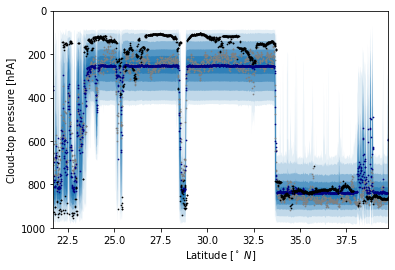

In [580]:
f, ax = plt.subplots(1, 1)
plot_confidence_intervals(ax, lats_c, y_pred, qrnn.quantiles)
ax.scatter(lats_c, y_pred_xgb, c="grey", marker=".", s=2)
ax.scatter(lats_c, y_pred_qrnn, c="navy", marker=".", s=2)
ax.scatter(lats_c, y_ref, c="k", marker=".", s=2)

ax.set_xlim([lats_c.min(), lats_c.max()])
ax.set_ylim([0, 1000])
ax.invert_yaxis()
ax.set_ylabel("Cloud-top pressure [hPA]")
ax.set_xlabel("Latitude [$^\circ\ N$]")

## Using a discrete output distribution

In [11]:
n_bins = 100
boundaries = np.linspace(0, 1100, n_bins + 1).reshape(1, -1)
y_cat = y_train > boundaries
y_cat = np.diff(y_cat, axis=1)
y_cat[:, 0] += y_train.ravel() < 0
y_cat[:, -1] += y_train.ravel() > 1100
y_cat = np.where(y_cat)[1]

In [12]:
y_train.size


2386246

In [13]:
y_cat.size

2386246

In [14]:
import torch
import torch.nn as nn

n_layers = 4
n_neurons = 256

# First block
layers = [nn.Linear(16, n_neurons), nn.BatchNorm1d(n_neurons), nn.ReLU(), ]
# Center blocks
for _ in range(n_layers):
    layers.extend([nn.Linear(n_neurons, n_neurons), nn.BatchNorm1d(n_neurons), nn.ReLU()])
# Final block
layers.append(nn.Linear(n_neurons, n_bins))

model = nn.Sequential(*layers)

In [15]:
def train_network(model,
                  training_data,
                  loss,
                  optimizer,
                  n_epochs,
                  scheduler=None,
                  device=torch.device("cpu")):
    """
    The standard training loop. For the given number of epochs, this
    functions loops over batches in the given training data, calculates
    the loss and updates training parameters and scheduler.
    
    Args:
        model(torch.nn.Module): The neural network model to train.
        training_data(Iterable): Iterable providing access to batches in training data.
        loss: The loss function to minimize.
        optimizer: PyTorch optimizer object to use to traing the network.
        scheduler: Learning rate scheduler object.
        n_epochs: The number of epochs for which to train the network.
    """
    model.to(device)
    model.train()
    
    for i in range(n_epochs):
        epoch_loss = 0
        for j, (x, y) in enumerate(training_data):
            
            x = x.to(device)
            y = y.to(device)
            
            # Clear gradients.
            optimizer.zero_grad()
            
            # Forward propagate input.
            y_pred = model(x)
            
            # Ensure output is of right size.
            batch_size = x.shape[0]
            y_pred = y_pred.reshape(batch_size, -1)
            y = y
            l = loss(y_pred, y)
            
            # Calculate gradients
            l.backward()
            
            # Update parameters and LR scheduler.
            optimizer.step()
            if scheduler:
                scheduler.step()
            
            epoch_loss += l.item()
            print(f"Epoch {i:2}: Batch {j} / {len(training_data)}, loss = {l.item():6.3}", end="\r")
        print(f"Epoch {i:2}: Avg. loss = {epoch_loss / j:6.3}", end="\n")
    model.eval()
    model.to(torch.device("cpu"))

In [16]:
x_tensor = torch.tensor(x_train).float()
y_tensor = torch.tensor(y_cat)
training_data = TensorDataset(x_tensor, y_tensor)
training_loader = DataLoader(training_data,
                             batch_size=256,
                             shuffle=True,
                             num_workers=4)

In [17]:
loss = nn.CrossEntropyLoss()
device = torch.device("cuda")
n_epochs = 10 
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
train_network(model, training_loader, loss, optimizer, n_epochs, scheduler=scheduler, device=device)

n_epochs = 10 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
train_network(model, training_loader, loss, optimizer, n_epochs, scheduler=scheduler, device=device)

n_epochs = 10 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
train_network(model, training_loader, loss, optimizer, n_epochs, scheduler=scheduler, device=device)

Epoch  0: Avg. loss =   3.67 loss =   3.78
Epoch  1: Avg. loss =   3.63 loss =   3.55
Epoch  2: Avg. loss =   3.61 loss =   3.61
Epoch  3: Avg. loss =    3.6 loss =   3.72
Epoch  4: Avg. loss =   3.59 loss =   3.77
Epoch  5: Avg. loss =   3.58 loss =   3.61
Epoch  6: Avg. loss =   3.57 loss =   3.72
Epoch  7: Avg. loss =   3.56 loss =   3.69
Epoch  8: Avg. loss =   3.55 loss =   3.56
Epoch  9: Avg. loss =   3.54 loss =    3.6
Epoch  0: Avg. loss =   3.51 loss =   3.49
Epoch  1: Avg. loss =   3.51 loss =   3.57
Epoch  2: Avg. loss =    3.5 loss =   3.49
Epoch  3: Avg. loss =    3.5 loss =   3.47
Epoch  4: Avg. loss =    3.5 loss =    3.5
Epoch  5: Avg. loss =    3.5 loss =   3.57
Epoch  6: Avg. loss =   3.49 loss =   3.46
Epoch  7: Avg. loss =   3.49 loss =   3.67
Epoch  8: Avg. loss =   3.49 loss =   3.37
Epoch  9: Avg. loss =   3.49 loss =    3.4
Epoch  0: Avg. loss =   3.48 loss =   3.53
Epoch  1: Avg. loss =   3.48 loss =   3.59
Epoch  2: Avg. loss =   3.48 loss =   3.44
Epoch  3: A

In [21]:
from torch.nn.functional import softmax
y_pred_cat = softmax(model(torch.tensor(normalizer(input_data)).float()), dim=1).detach().numpy()

In [47]:
y.shape

(100,)

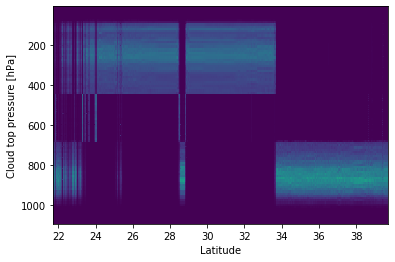

In [53]:
y = 0.5 * (boundaries[0, 1:] + boundaries[0, :-1])
f, ax = plt.subplots(1, 1)
ax.pcolormesh(lats_c[:-3], y, (y_pred_cat / norm).T[:, :-3])
ax.set_xlabel("Latitude")
ax.set_ylabel("Cloud top pressure [hPa]")
ax.invert_yaxis()

In [26]:
norm = np.sum(y_pred_cat, axis=1, keepdims=True)
y_pred_cdf = np.cumsum(y_pred_cat / norm, axis=1)


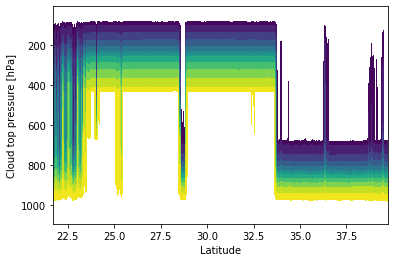

In [58]:
f, ax = plt.subplots(1, 1)
ax.contourf(lats_c, y, y_pred_cdf.T, levels=quantiles)
ax.set_xlabel("Latitude")
ax.set_ylabel("Cloud top pressure [hPa]")
ax.invert_yaxis()

In [635]:
train_network(model, training_loader, loss, optimizer, n_epochs, scheduler=scheduler)

KeyboardInterrupt: 